## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create figures directory if it doesn't exist
os.makedirs('../paper/figures', exist_ok=True)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 150

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the occupation-level panel
df = pd.read_csv('../data/occupation_panel.csv', low_memory=False)

# Convert numeric columns (handle BLS suppression symbols)
numeric_cols = ['Employment', 'Hourly_Mean_Wage', 'Annual_Mean_Wage', 'LogEmployment']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Occupation Panel Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nPanel Structure:")
print(f"  States: {df['State'].nunique()}")
print(f"  Industries: {df['Industry'].nunique()}")
print(f"  Occupations: {df['Occupation'].nunique()}")
print(f"  Years: {df['Year'].nunique()}")
print(f"\nTreatment Split:")
print(f"  Pre (2015-2022): {(df['Post'] == 0).sum():,}")
print(f"  Post (2023-2024): {(df['Post'] == 1).sum():,}")

Occupation Panel Shape: (7108826, 17)

Columns: ['State_Code', 'State', 'Industry_Code', 'Industry', 'Occupation_Code', 'Occupation', 'Employment', 'Hourly_Mean_Wage', 'Annual_Mean_Wage', 'Year', 'LogEmployment', 'Post', 'AI_Exposure_Score', 'Teleworkability', 'RoutineTaskIndex', 'SkillIntensity', 'AutomationRisk_PreAI']

Panel Structure:
  States: 54
  Industries: 511
  Occupations: 1004
  Years: 10

Treatment Split:
  Pre (2015-2022): 5,538,093
  Post (2023-2024): 1,570,733


In [3]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7108826 entries, 0 to 7108825
Data columns (total 17 columns):
 #   Column                Dtype  
---  ------                -----  
 0   State_Code            int64  
 1   State                 object 
 2   Industry_Code         object 
 3   Industry              object 
 4   Occupation_Code       object 
 5   Occupation            object 
 6   Employment            float64
 7   Hourly_Mean_Wage      float64
 8   Annual_Mean_Wage      float64
 9   Year                  int64  
 10  LogEmployment         float64
 11  Post                  int64  
 12  AI_Exposure_Score     float64
 13  Teleworkability       float64
 14  RoutineTaskIndex      float64
 15  SkillIntensity        float64
 16  AutomationRisk_PreAI  float64
dtypes: float64(9), int64(3), object(5)
memory usage: 922.0+ MB


In [4]:
# First few rows
df.head(10)

,State_Code,State,Industry_Code,Industry,Occupation_Code,Occupation,Employment,Hourly_Mean_Wage,Annual_Mean_Wage,Year,LogEmployment,Post,AI_Exposure_Score,Teleworkability,RoutineTaskIndex,SkillIntensity,AutomationRisk_PreAI
0,1,Alabama,sector,"Agriculture, Forestry, Fishing and Hunting",11-1021,General and Operations Managers,60.0,49.43,102820.0,2015,4.094345,0,NaN,NaN,NaN,NaN,NaN
1,1,Alabama,sector,"Agriculture, Forestry, Fishing and Hunting",43-3031,"Bookkeeping, Accounting, and Auditing Clerks",30.0,17.89,37200.0,2015,3.401197,0,NaN,NaN,NaN,NaN,NaN
2,1,Alabama,sector,"Agriculture, Forestry, Fishing and Hunting",43-6014,"Secretaries and Administrative Assistants, Exc...",160.0,14.22,29570.0,2015,5.075174,0,NaN,NaN,NaN,NaN,NaN
3,1,Alabama,sector,"Agriculture, Forestry, Fishing and Hunting",43-9061,"Office Clerks, General",140.0,10.02,20850.0,2015,4.941642,0,NaN,NaN,NaN,NaN,NaN
4,1,Alabama,sector,"Agriculture, Forestry, Fishing and Hunting",45-1011,"First-Line Supervisors of Farming, Fishing, an...",260.0,23.43,48740.0,2015,5.560682,0,NaN,NaN,NaN,NaN,NaN
5,1,Alabama,sector,"Agriculture, Forestry, Fishing and Hunting",45-2091,Agricultural Equipment Operators,80.0,9.94,20680.0,2015,4.382027,0,NaN,NaN,NaN,NaN,NaN
6,1,Alabama,sector,"Agriculture, Forestry, Fishing and Hunting",45-2093,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",590.0,11.25,23400.0,2015,6.380123,0,NaN,NaN,NaN,NaN,NaN
7,1,Alabama,sector,"Agriculture, Forestry, Fishing and Hunting",45-4022,Logging Equipment Operators,2240.0,15.97,33220.0,2015,7.714231,0,NaN,NaN,NaN,NaN,NaN
8,1,Alabama,sector,"Agriculture, Forestry, Fishing and Hunting",45-4029,"Logging Workers, All Other",50.0,16.48,34280.0,2015,3.912023,0,NaN,NaN,NaN,NaN,NaN
9,1,Alabama,sector,"Agriculture, Forestry, Fishing and Hunting",49-3042,"Mobile Heavy Equipment Mechanics, Except Engines",60.0,16.18,33650.0,2015,4.094345,0,NaN,NaN,NaN,NaN,NaN


## 2. Summary Statistics

In [5]:
# Overall summary statistics
df.describe()

,State_Code,Employment,Hourly_Mean_Wage,Annual_Mean_Wage,Year,LogEmployment,Post,AI_Exposure_Score,Teleworkability,RoutineTaskIndex,SkillIntensity,AutomationRisk_PreAI
count,7.108826e+06,7.108826e+06,6.932774e+06,7.038670e+06,7.108826e+06,7.108826e+06,7.108826e+06,0.0,0.0,0.0,0.0,0.0
mean,2.940387e+01,1.526979e+03,3.002701e+01,6.259094e+04,2.019774e+03,5.442159e+00,2.209553e-01,NaN,NaN,NaN,NaN,NaN
std,1.623636e+01,1.375413e+04,1.751700e+01,3.637576e+04,2.820169e+00,1.525776e+00,4.148905e-01,NaN,NaN,NaN,NaN,NaN
min,1.000000e+00,3.000000e+01,7.250000e+00,1.508000e+04,2.015000e+03,3.401197e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
25%,1.700000e+01,7.000000e+01,1.813000e+01,3.781000e+04,2.017000e+03,4.248495e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
50%,2.900000e+01,1.700000e+02,2.506000e+01,5.239000e+04,2.020000e+03,5.135798e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
75%,4.200000e+01,5.500000e+02,3.681000e+01,7.684000e+04,2.022000e+03,6.309918e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
max,7.800000e+01,2.945580e+06,8.481600e+02,1.764170e+06,2.024000e+03,1.489582e+01,1.000000e+00,NaN,NaN,NaN,NaN,NaN


In [6]:
# Summary by treatment status
print("=" * 70)
print("OCCUPATION-LEVEL PANEL SUMMARY")
print("=" * 70)
print(f"\nTotal Observations: {len(df):,}")
print(f"Unique States: {df['State'].nunique()}")
print(f"Unique Industries: {df['Industry'].nunique()}")
print(f"Unique Occupations: {df['Occupation_Code'].nunique()}")
print(f"Time Period: {df['Year'].min()} to {df['Year'].max()}")

print(f"\n{'Period':<30} {'Observations':<15} {'Percent'}")
print("-" * 60)
print(f"{'Pre-treatment (2015-2022)':<30} {(df['Post'] == 0).sum():<15,} {(df['Post'] == 0).sum()/len(df)*100:>6.1f}%")
print(f"{'Post-treatment (2023-2024)':<30} {(df['Post'] == 1).sum():<15,} {(df['Post'] == 1).sum()/len(df)*100:>6.1f}%")

print(f"\n{'Employment Stats':<30} {'Value'}")
print("-" * 60)
print(f"{'Mean employment':<30} {df['Employment'].mean():>15,.0f}")
print(f"{'Median employment':<30} {df['Employment'].median():>15,.0f}")
print(f"{'Total employment (sum)':<30} {df['Employment'].sum():>15,.0f}")

OCCUPATION-LEVEL PANEL SUMMARY

Total Observations: 7,108,826
Unique States: 54
Unique Industries: 511
Unique Occupations: 832
Time Period: 2015 to 2024

Period                         Observations    Percent
------------------------------------------------------------
Pre-treatment (2015-2022)      5,538,093         77.9%
Post-treatment (2023-2024)     1,570,733         22.1%

Employment Stats               Value
------------------------------------------------------------
Mean employment                          1,527
Median employment                          170
Total employment (sum)          10,855,029,880


In [7]:
# Top 20 occupations by total employment
print("\n" + "=" * 70)
print("TOP 20 OCCUPATIONS BY TOTAL EMPLOYMENT")
print("=" * 70)

top_occupations = df.groupby(['Occupation_Code', 'Occupation'])['Employment'].sum().sort_values(ascending=False).head(20)
for i, ((code, title), emp) in enumerate(top_occupations.items(), 1):
    print(f"{i:2}. {code:10} | {title[:45]:45} | {emp:>15,.0f}")

# Industry summary
print("\n" + "=" * 70)
print("INDUSTRY SUMMARY (Sample of Industries)")
print("=" * 70)

industry_summary = df.groupby('Industry').agg({
    'Employment': ['sum', 'mean', 'count'],
    'Occupation_Code': 'nunique'
}).round(0)
industry_summary.columns = ['Total_Emp', 'Mean_Emp', 'Observations', 'N_Occupations']
industry_summary = industry_summary.sort_values('Total_Emp', ascending=False).head(15)
print(industry_summary.to_string())


TOP 20 OCCUPATIONS BY TOTAL EMPLOYMENT
 1. total      | All Occupations                               |   3,274,829,160
 2. major      | Office and Administrative Support Occupations |     422,858,610
 3. major      | Food Preparation and Serving Related Occupati |     300,353,550
 4. major      | Sales and Related Occupations                 |     296,370,970
 5. major      | Transportation and Material Moving Occupation |     271,254,230
 6. major      | Management Occupations                        |     200,002,460
 7. major      | Business and Financial Operations Occupations |     198,991,060
 8. major      | Healthcare Practitioners and Technical Occupa |     197,192,790
 9. major      | Production Occupations                        |     189,534,600
10. major      | Educational Instruction and Library Occupatio |     155,790,200
11. major      | Healthcare Support Occupations                |     149,802,840
12. major      | Construction and Extraction Occupations       |     

In [8]:
# Check exposure score variables (currently placeholders)
print("\n" + "=" * 70)
print("OCCUPATION EXPOSURE SCORES (TO BE ADDED)")
print("=" * 70)

exposure_vars = ['AI_Exposure_Score', 'Teleworkability', 'RoutineTaskIndex', 
                 'SkillIntensity', 'AutomationRisk_PreAI']

print(f"\n{'Variable':<30} {'Non-null Count':<20} {'Data Available'}")
print("-" * 70)
for var in exposure_vars:
    non_null = df[var].notna().sum()
    pct = non_null / len(df) * 100
    status = "✓ YES" if non_null > 0 else "✗ NOT YET"
    print(f"{var:<30} {non_null:<20,} ({pct:>5.1f}%)  {status}")

print("\nNote: These scores will be matched using SOC occupation codes.")
print("Required sources:")
print("  1. ILO GPT Exposure Index (ISCO-08 → SOC crosswalk)")
print("  2. Dingel & Neiman Teleworkability (SOC)")
print("  3. Autor & Dorn Routine Task Index (SOC via O*NET)")
print("  4. O*NET Skill Intensity (SOC)")
print("  5. Frey & Osborne Automation Risk (SOC)")


OCCUPATION EXPOSURE SCORES (TO BE ADDED)

Variable                       Non-null Count       Data Available
----------------------------------------------------------------------
AI_Exposure_Score              0                    (  0.0%)  ✗ NOT YET
Teleworkability                0                    (  0.0%)  ✗ NOT YET
RoutineTaskIndex               0                    (  0.0%)  ✗ NOT YET
SkillIntensity                 0                    (  0.0%)  ✗ NOT YET
AutomationRisk_PreAI           0                    (  0.0%)  ✗ NOT YET

Note: These scores will be matched using SOC occupation codes.
Required sources:
  1. ILO GPT Exposure Index (ISCO-08 → SOC crosswalk)
  2. Dingel & Neiman Teleworkability (SOC)
  3. Autor & Dorn Routine Task Index (SOC via O*NET)
  4. O*NET Skill Intensity (SOC)
  5. Frey & Osborne Automation Risk (SOC)


## 3. Employment Trends Over Time

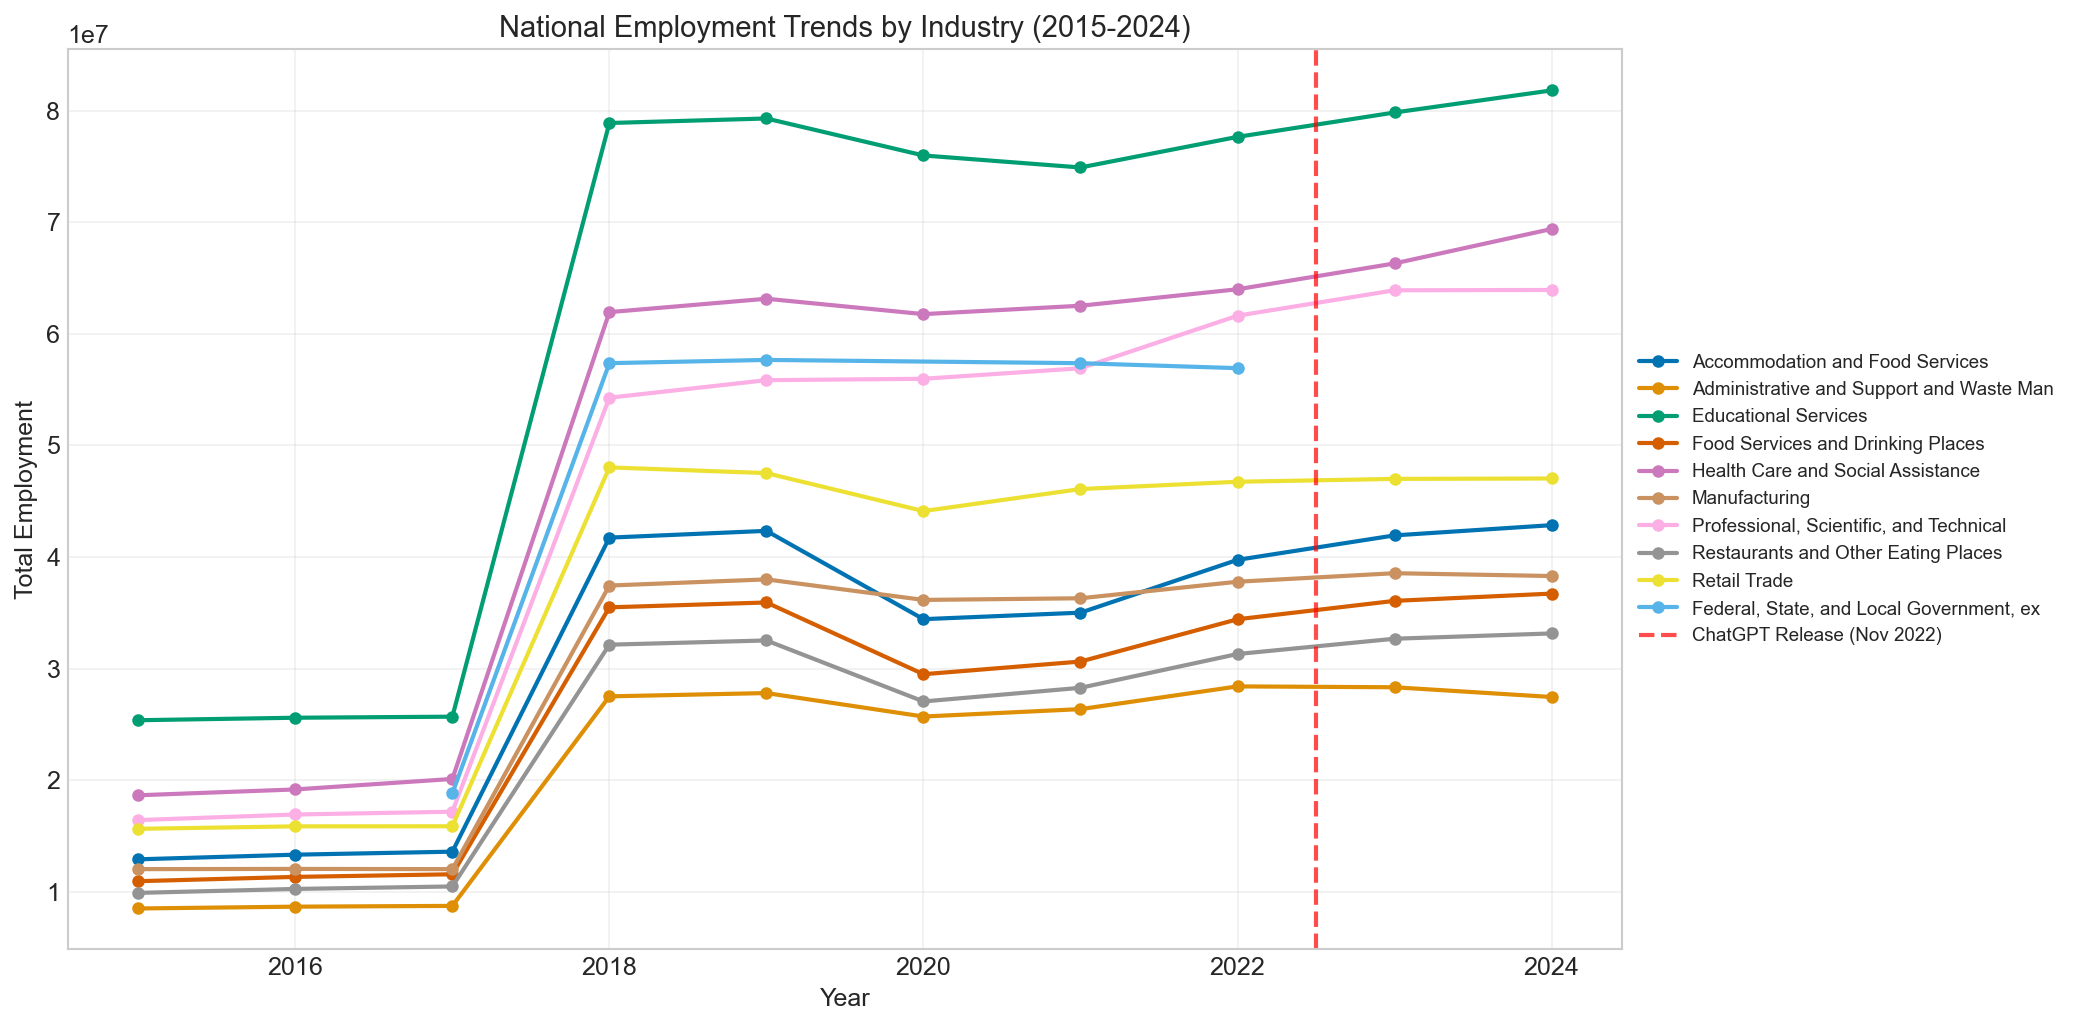

Saved: employment_trends_raw.pdf


In [9]:
# Aggregate to national level for time trends
# Sum employment across all states and occupations by industry and year
national = df.groupby(['Year', 'Industry'])['Employment'].sum().reset_index()

# Get top 10 industries by total employment
top_industries = df.groupby('Industry')['Employment'].sum().sort_values(ascending=False).head(10).index
national_top = national[national['Industry'].isin(top_industries)]

fig, ax = plt.subplots(figsize=(14, 7))

for industry in national_top['Industry'].unique():
    ind_data = national_top[national_top['Industry'] == industry]
    ax.plot(ind_data['Year'], ind_data['Employment'], 
            label=industry[:40], linewidth=2, marker='o', markersize=5)

# Add vertical line for ChatGPT release (Nov 2022 → use 2023 as treatment year)
ax.axvline(2022.5, color='red', linestyle='--', linewidth=2, alpha=0.7,
           label='ChatGPT Release (Nov 2022)')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Employment', fontsize=12)
ax.set_title('National Employment Trends by Industry (2015-2024)', fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../paper/figures/employment_trends_raw.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../paper/figures/employment_trends_raw.png', bbox_inches='tight', dpi=300)
plt.show()
print("Saved: employment_trends_raw.pdf")

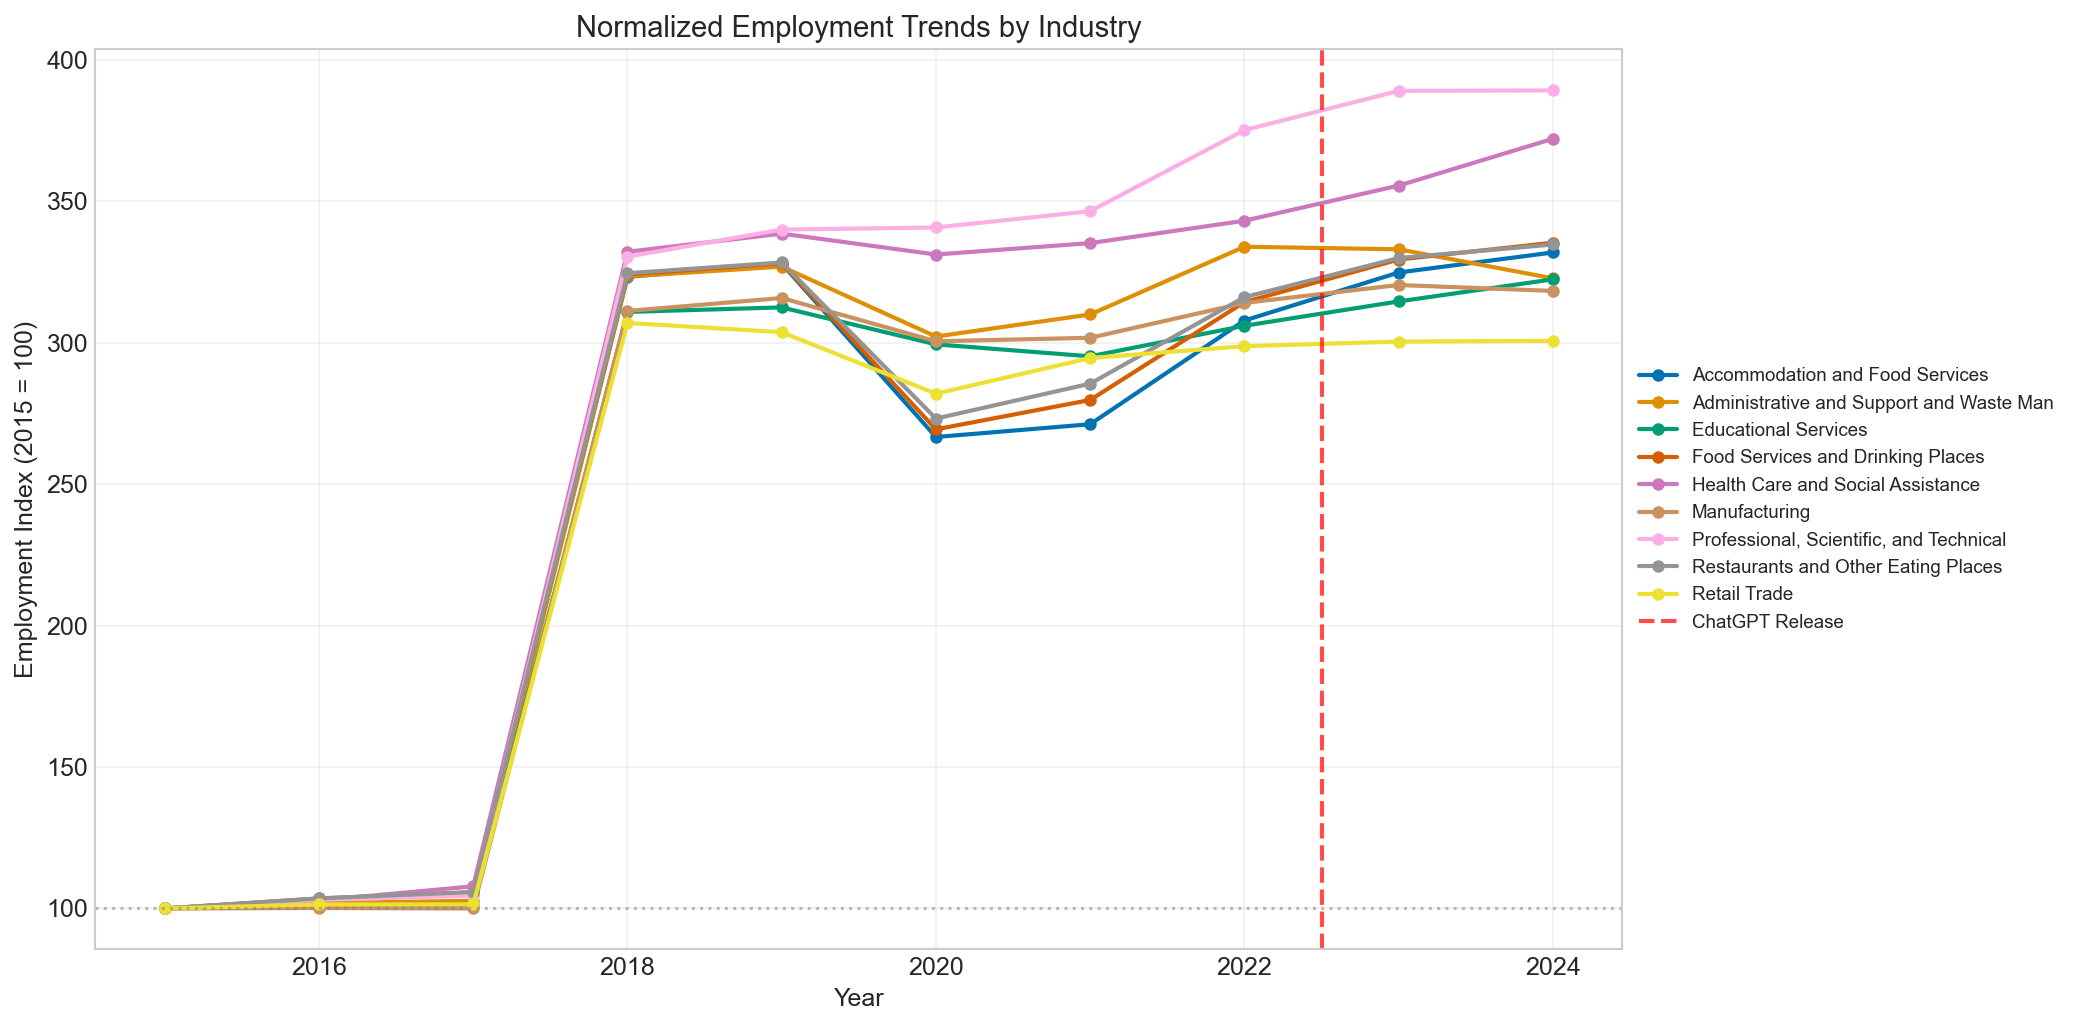

Saved: employment_trends_normalized.pdf


In [10]:
# Normalized employment trends (index to 100 at 2015)
baseline_year = 2015

fig, ax = plt.subplots(figsize=(14, 7))

for industry in national_top['Industry'].unique():
    ind_data = national_top[national_top['Industry'] == industry].copy()
    baseline_emp = ind_data[ind_data['Year'] == baseline_year]['Employment'].values
    if len(baseline_emp) > 0 and baseline_emp[0] > 0:
        ind_data['Normalized'] = (ind_data['Employment'] / baseline_emp[0]) * 100
        ax.plot(ind_data['Year'], ind_data['Normalized'], 
                label=industry[:40], linewidth=2, marker='o', markersize=5)

ax.axvline(2022.5, color='red', linestyle='--', linewidth=2, alpha=0.7,
           label='ChatGPT Release')
ax.axhline(100, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Employment Index (2015 = 100)', fontsize=12)
ax.set_title('Normalized Employment Trends by Industry', fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../paper/figures/employment_trends_normalized.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../paper/figures/employment_trends_normalized.png', bbox_inches='tight', dpi=300)
plt.show()
print("Saved: employment_trends_normalized.pdf")

## 4. Pre-Treatment Parallel Trends Check

A key assumption of DiD is that treatment and control groups would have followed parallel trends in the absence of treatment.

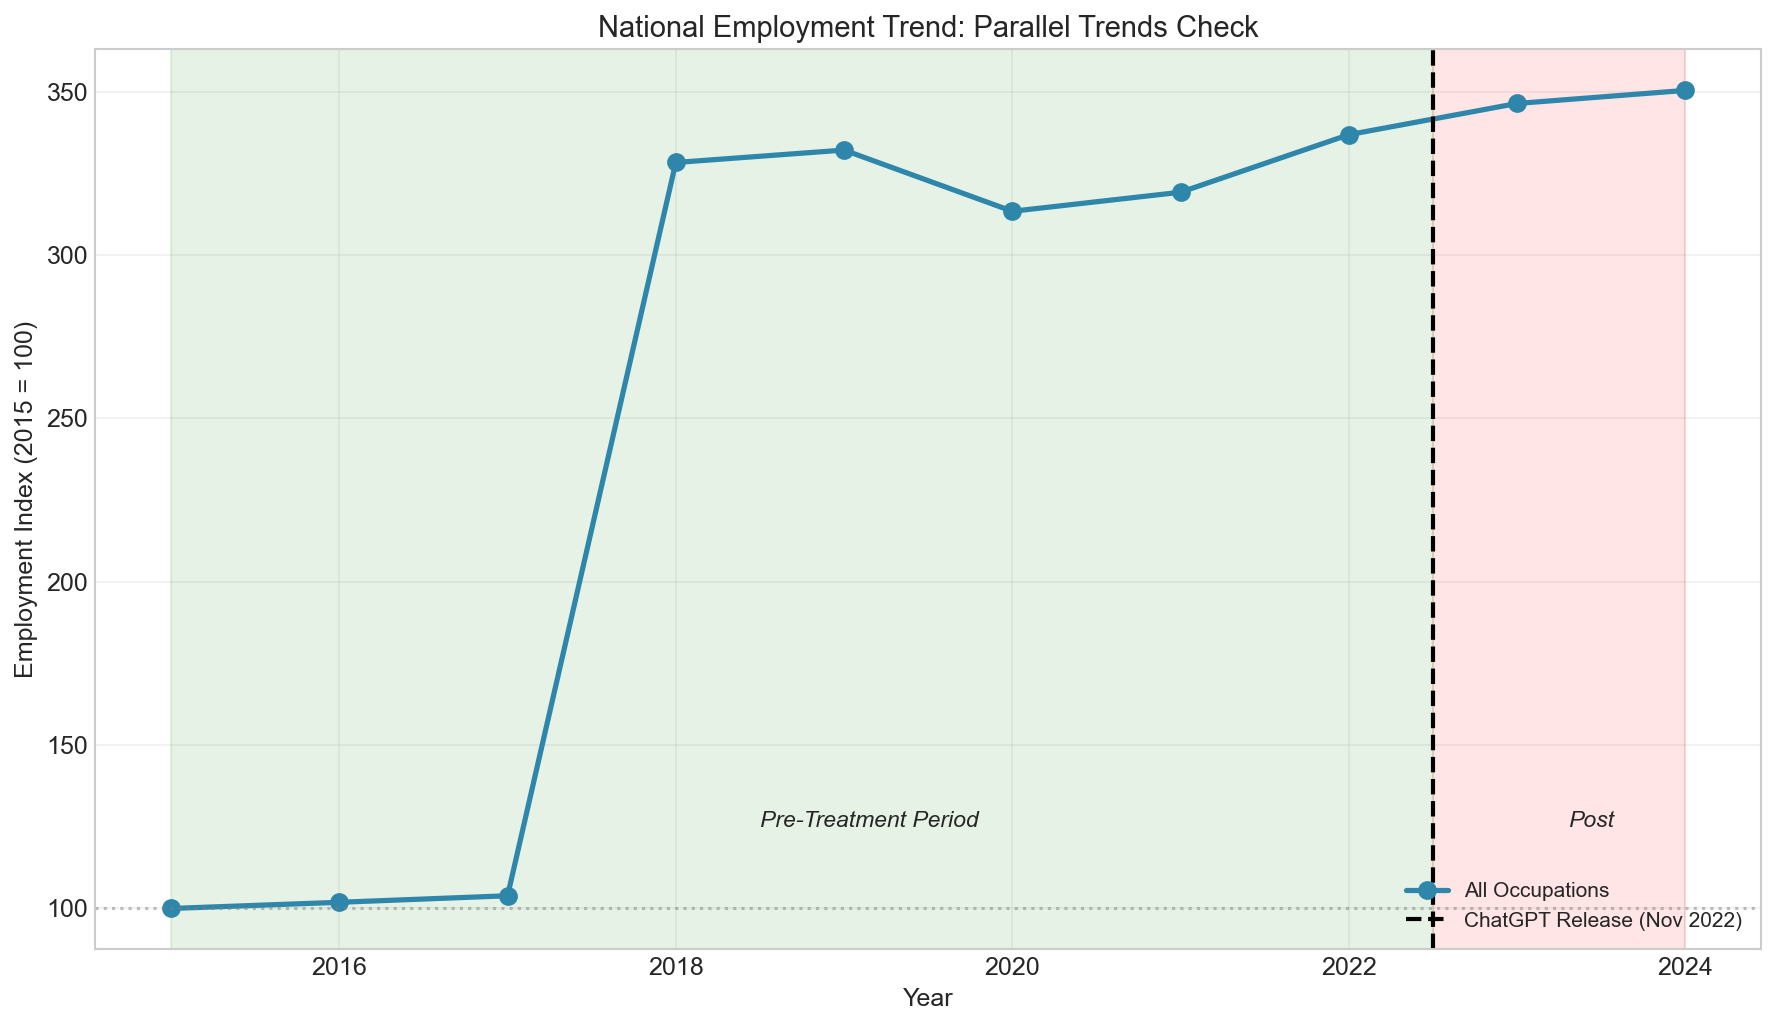

Saved: parallel_trends.pdf

Note: Once AI exposure scores are added, we'll compare high vs low exposure occupations.


In [11]:
# Parallel Trends Check - comparing pre and post periods
# Note: Will be more meaningful once we have AI exposure scores by occupation
# For now, compare all occupations pre vs post

# Aggregate to national level by year
national_total = df.groupby('Year')['Employment'].sum().reset_index()

# Calculate year-over-year growth
national_total['Normalized'] = (national_total['Employment'] / national_total.iloc[0]['Employment']) * 100

fig, ax = plt.subplots(figsize=(12, 7))

# Plot trend
ax.plot(national_total['Year'], national_total['Normalized'], 
        linewidth=2.5, color='#2E86AB', marker='o', markersize=8,
        label='All Occupations')

# Mark treatment period
ax.axvline(2022.5, color='black', linestyle='--', linewidth=2, 
           label='ChatGPT Release (Nov 2022)')
ax.axvspan(2015, 2022.5, alpha=0.1, color='green')
ax.axvspan(2022.5, 2024, alpha=0.1, color='red')

# Add text annotations
ax.text(2018.5, 125, 'Pre-Treatment Period', fontsize=11, style='italic')
ax.text(2023.3, 125, 'Post', fontsize=11, style='italic')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Employment Index (2015 = 100)', fontsize=12)
ax.set_title('National Employment Trend: Parallel Trends Check', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(100, color='gray', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.savefig('../paper/figures/parallel_trends.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../paper/figures/parallel_trends.png', bbox_inches='tight', dpi=300)
plt.show()
print("Saved: parallel_trends.pdf")
print("\nNote: Once AI exposure scores are added, we'll compare high vs low exposure occupations.")

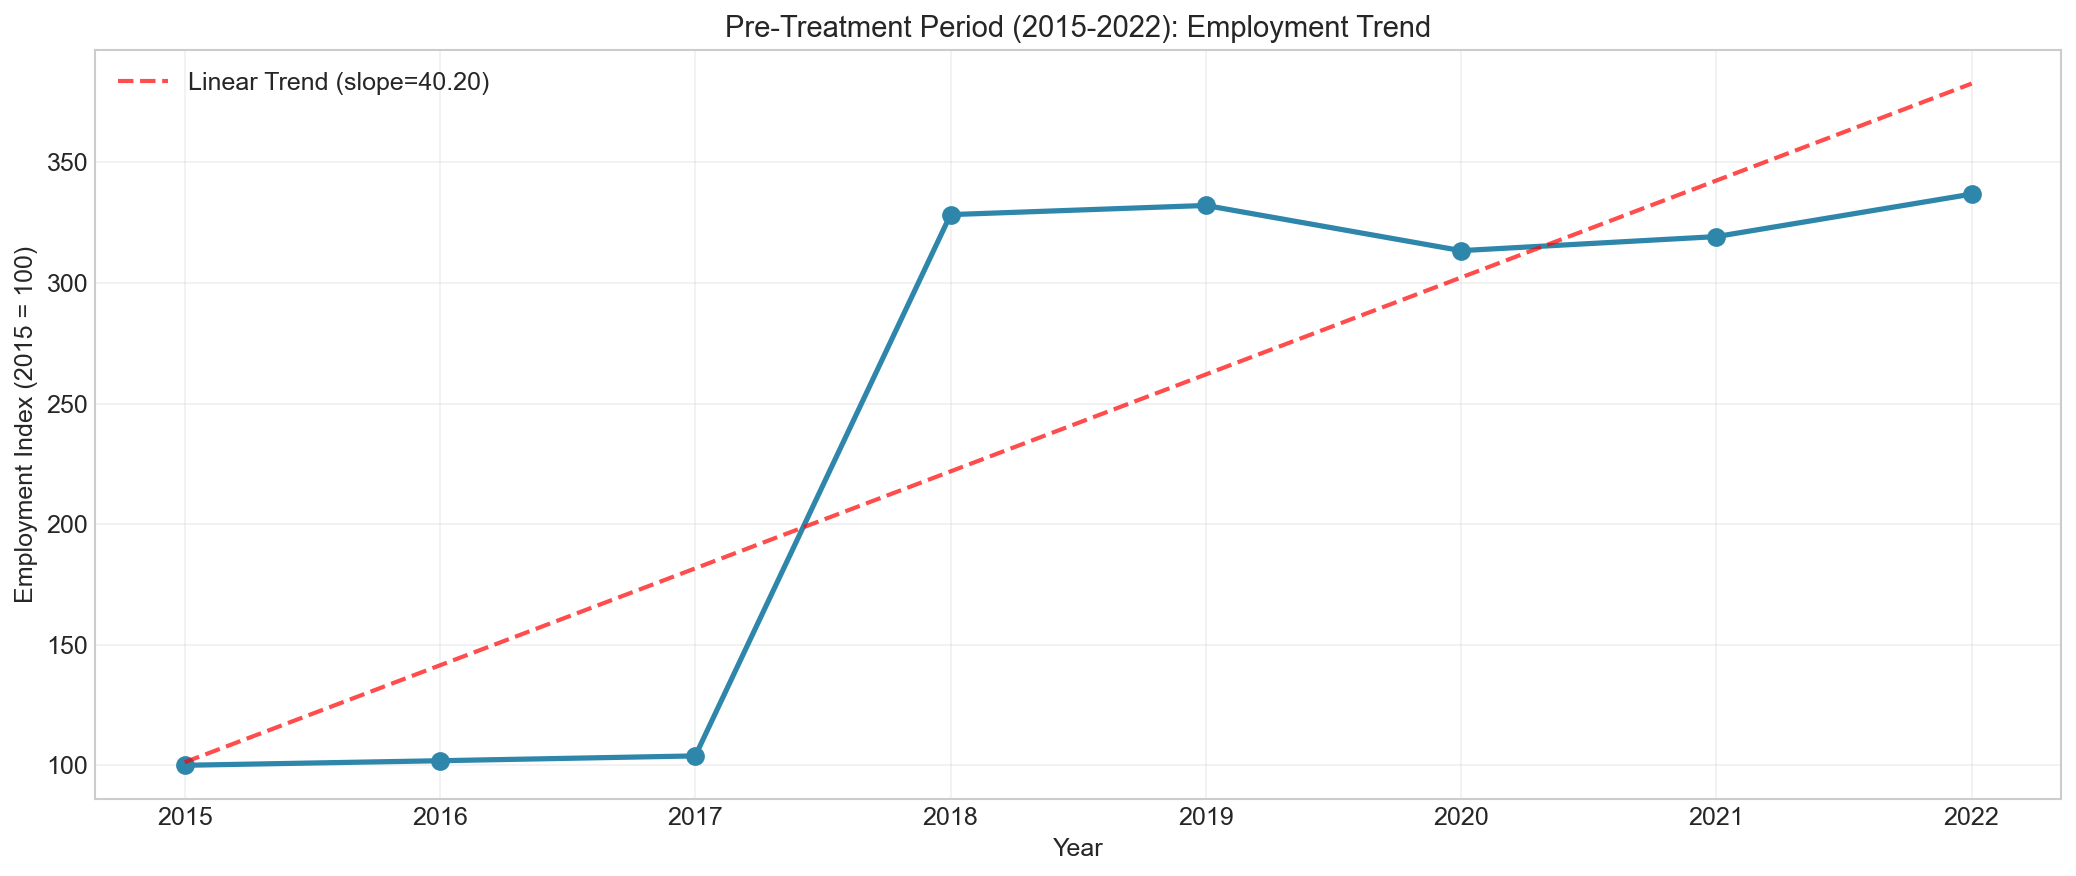


Pre-treatment trend summary:
  Average annual growth: 40.20 index points/year
  Total change (2015-2022): 236.9%

Note: Once exposure scores are available, test for parallel trends between high/low exposure groups.


In [12]:
# Pre-period trend analysis
pre_period = national_total[national_total['Year'] < 2023].copy()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(pre_period['Year'], pre_period['Normalized'], 
        linewidth=2.5, color='#2E86AB', marker='o', markersize=8)

# Add trend line
z = np.polyfit(pre_period['Year'], pre_period['Normalized'], 1)
p = np.poly1d(z)
ax.plot(pre_period['Year'], p(pre_period['Year']), 
        linestyle='--', color='red', linewidth=2, alpha=0.7,
        label=f'Linear Trend (slope={z[0]:.2f})')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Employment Index (2015 = 100)', fontsize=12)
ax.set_title('Pre-Treatment Period (2015-2022): Employment Trend', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPre-treatment trend summary:")
print(f"  Average annual growth: {z[0]:.2f} index points/year")
print(f"  Total change (2015-2022): {pre_period.iloc[-1]['Normalized'] - 100:.1f}%")
print("\nNote: Once exposure scores are available, test for parallel trends between high/low exposure groups.")

## 5. Difference-in-Differences Visual

In [13]:
# Simple pre-post comparison (will be refined with exposure scores)
did_data = df.groupby('Post')['Employment'].sum().reset_index()

pre_emp = did_data[did_data['Post'] == 0]['Employment'].values[0]
post_emp = did_data[did_data['Post'] == 1]['Employment'].values[0]

# Normalize
pre_norm = 100
post_norm = (post_emp / pre_emp) * 100
change = post_norm - pre_norm

print("=" * 70)
print("PRE-POST COMPARISON (Simple Difference)")
print("=" * 70)
print(f"\nPre-treatment period (2015-2022):")
print(f"  Total employment: {pre_emp:,.0f}")
print(f"  Index: {pre_norm:.1f}")

print(f"\nPost-treatment period (2023-2024):")
print(f"  Total employment: {post_emp:,.0f}")
print(f"  Index: {post_norm:.1f}")

print(f"\nChange: {change:+.2f}%")

print("\n" + "=" * 70)
print("NOTE: This is a simple before-after comparison.")
print("Proper DiD analysis requires:")
print("  1. AI exposure scores by occupation (to define treatment)")
print("  2. Control group (low exposure occupations)")
print("  3. State and industry fixed effects")
print("=" * 70)

PRE-POST COMPARISON (Simple Difference)

Pre-treatment period (2015-2022):
  Total employment: 7,981,818,170
  Index: 100.0

Post-treatment period (2023-2024):
  Total employment: 2,873,211,710
  Index: 36.0

Change: -64.00%

NOTE: This is a simple before-after comparison.
Proper DiD analysis requires:
  1. AI exposure scores by occupation (to define treatment)
  2. Control group (low exposure occupations)
  3. State and industry fixed effects


In [14]:
# Placeholder for DiD visualization (to be completed with exposure scores)
print("=" * 70)
print("DIFFERENCE-IN-DIFFERENCES ANALYSIS")
print("=" * 70)
print("\nStatus: WAITING FOR EXPOSURE SCORES")
print("\nOnce AI exposure scores are matched to occupations, we will:")
print("  1. Classify occupations as high/low AI exposure")
print("  2. Calculate group means: E[Y|High,Pre], E[Y|High,Post], E[Y|Low,Pre], E[Y|Low,Post]")
print("  3. Compute DiD estimate: [E[Y|High,Post] - E[Y|High,Pre]] - [E[Y|Low,Post] - E[Y|Low,Pre]]")
print("  4. Visualize parallel trends and DiD effect")
print("  5. Test for statistical significance with clustered standard errors")

print("\nExposure score data needed:")
exposure_vars = ['AI_Exposure_Score', 'Teleworkability', 'RoutineTaskIndex', 
                 'SkillIntensity', 'AutomationRisk_PreAI']
for var in exposure_vars:
    status = "✓" if df[var].notna().sum() > 0 else "✗"
    print(f"  {status} {var}")

print("\nSample DiD specification (once data is ready):")
print("  log(Employment_ijst) = β₀ + β₁(HighExposure_i × Post_t)")
print("                        + α_i + γ_t + δ_s + ε_ijst")
print("  where:")
print("    i = occupation, j = industry, s = state, t = year")
print("    α_i = occupation FE, γ_t = year FE, δ_s = state FE")
print("=" * 70)

DIFFERENCE-IN-DIFFERENCES ANALYSIS

Status: WAITING FOR EXPOSURE SCORES

Once AI exposure scores are matched to occupations, we will:
  1. Classify occupations as high/low AI exposure
  2. Calculate group means: E[Y|High,Pre], E[Y|High,Post], E[Y|Low,Pre], E[Y|Low,Post]
  3. Compute DiD estimate: [E[Y|High,Post] - E[Y|High,Pre]] - [E[Y|Low,Post] - E[Y|Low,Pre]]
  4. Visualize parallel trends and DiD effect
  5. Test for statistical significance with clustered standard errors

Exposure score data needed:
  ✗ AI_Exposure_Score
  ✗ Teleworkability
  ✗ RoutineTaskIndex
  ✗ SkillIntensity
  ✗ AutomationRisk_PreAI

Sample DiD specification (once data is ready):
  log(Employment_ijst) = β₀ + β₁(HighExposure_i × Post_t)
                        + α_i + γ_t + δ_s + ε_ijst
  where:
    i = occupation, j = industry, s = state, t = year
    α_i = occupation FE, γ_t = year FE, δ_s = state FE


## 6. State-Level Variation

In [15]:
# State-level summary
state_summary = df.groupby('State').agg({
    'Employment': 'sum',
    'Occupation_Code': 'nunique'
}).sort_values('Employment', ascending=False)
state_summary.columns = ['Total_Employment', 'N_Occupations']

print("=" * 70)
print("TOP 15 STATES BY TOTAL EMPLOYMENT")
print("=" * 70)
top_states = state_summary.head(15)
for i, (state, row) in enumerate(top_states.iterrows(), 1):
    print(f"{i:2}. {state:30} | Emp: {row['Total_Employment']:>15,.0f} | Occupations: {row['N_Occupations']:>4}")

print(f"\nNote: Data covers {df['State'].nunique()} states/territories")

TOP 15 STATES BY TOTAL EMPLOYMENT
 1. California                     | Emp:   1,301,401,970 | Occupations: 815.0
 2. Texas                          | Emp:     945,851,850 | Occupations: 806.0
 3. New York                       | Emp:     687,388,450 | Occupations: 788.0
 4. Florida                        | Emp:     670,564,720 | Occupations: 790.0
 5. Illinois                       | Emp:     437,301,170 | Occupations: 781.0
 6. Pennsylvania                   | Emp:     435,723,910 | Occupations: 795.0
 7. Ohio                           | Emp:     400,392,210 | Occupations: 775.0
 8. North Carolina                 | Emp:     336,444,010 | Occupations: 756.0
 9. Georgia                        | Emp:     330,777,150 | Occupations: 759.0
10. Michigan                       | Emp:     314,611,200 | Occupations: 770.0
11. New Jersey                     | Emp:     298,593,410 | Occupations: 756.0
12. Virginia                       | Emp:     284,767,550 | Occupations: 757.0
13. Massachusetts 

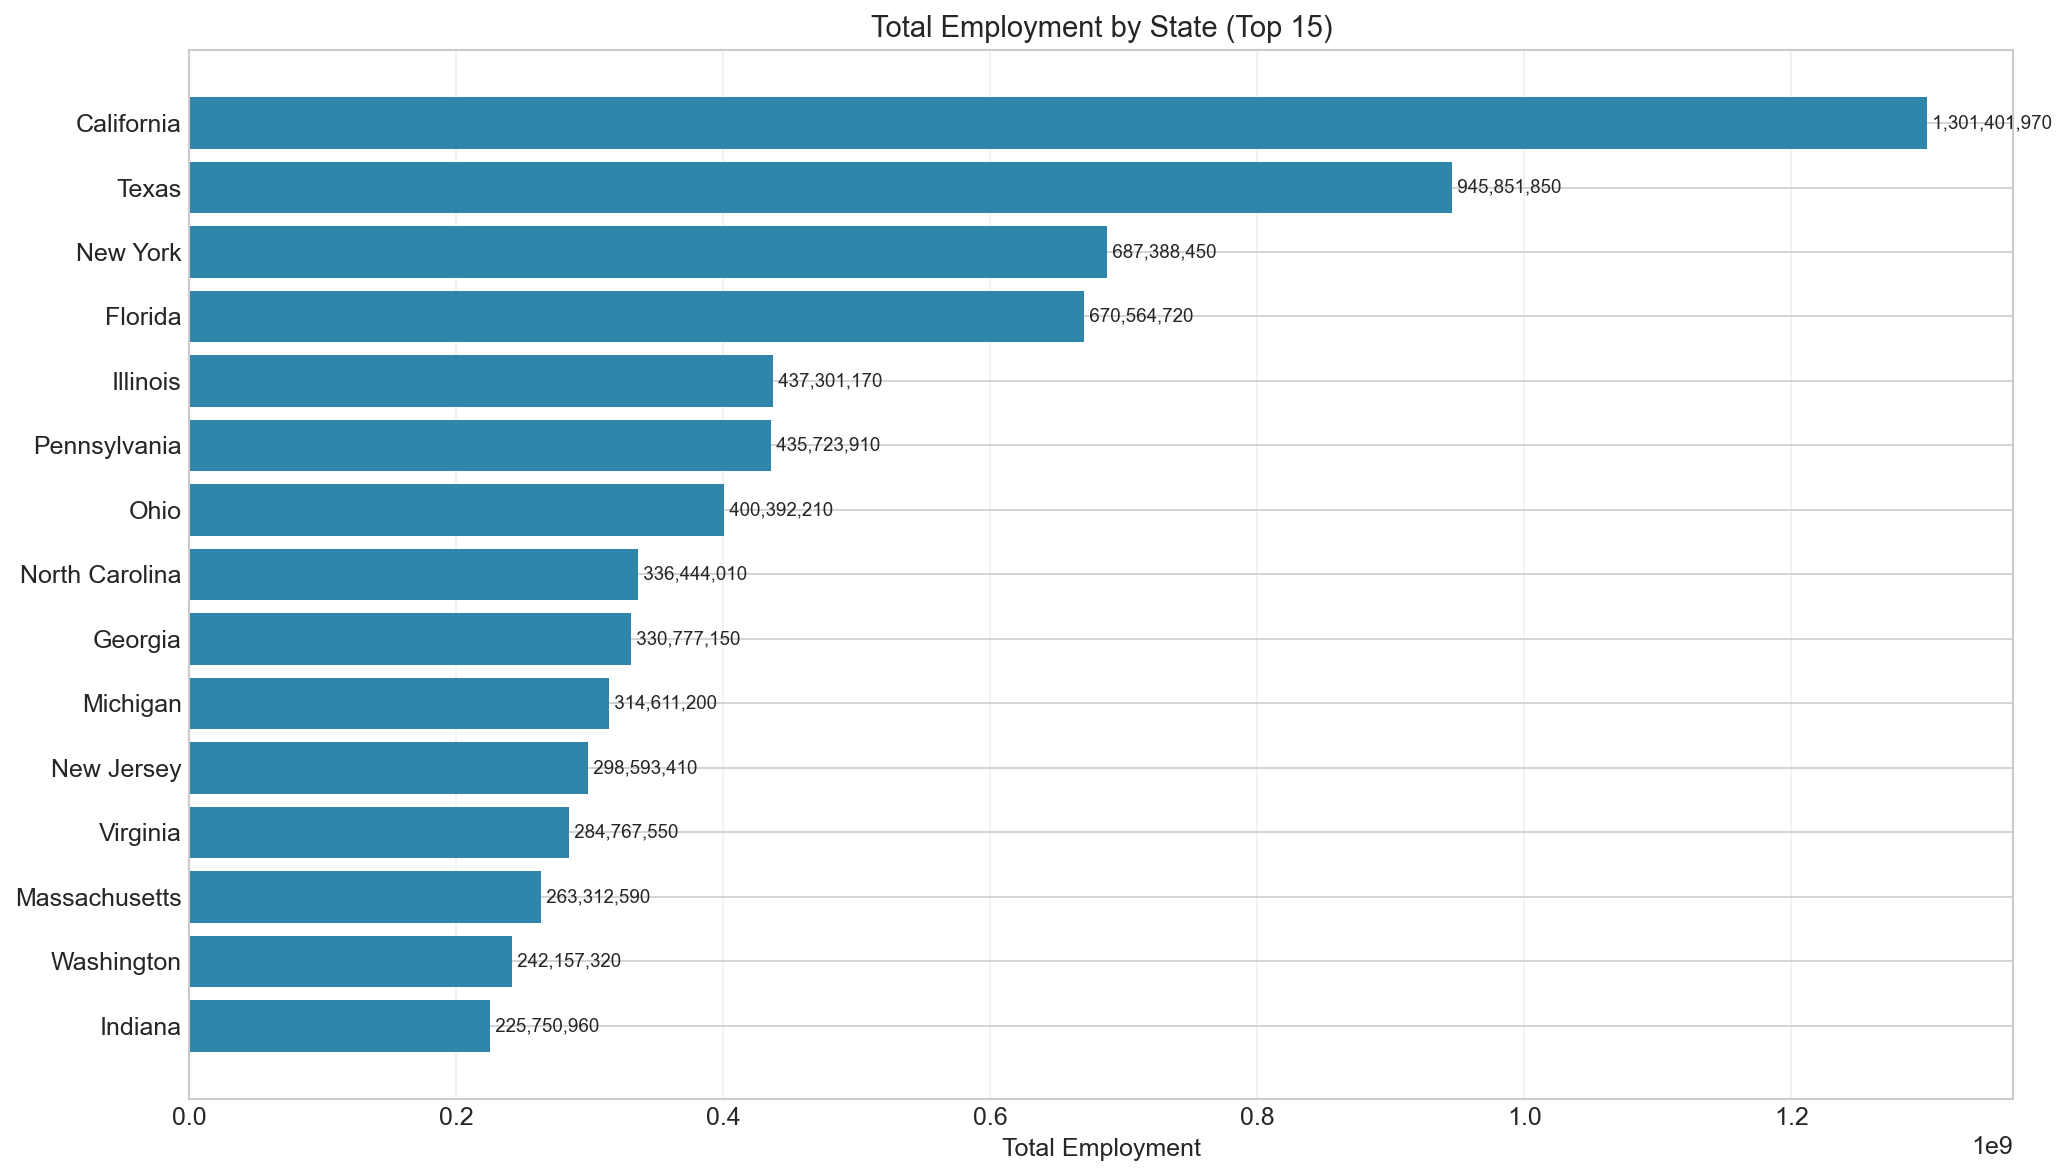

Note: Once exposure scores are added, we can analyze state-level heterogeneity in treatment effects.


In [16]:
# Employment distribution by state
fig, ax = plt.subplots(figsize=(14, 8))

top_15_states = state_summary.head(15).sort_values('Total_Employment')
ax.barh(range(len(top_15_states)), top_15_states['Total_Employment'], color='#2E86AB')
ax.set_yticks(range(len(top_15_states)))
ax.set_yticklabels(top_15_states.index)
ax.set_xlabel('Total Employment', fontsize=12)
ax.set_title('Total Employment by State (Top 15)', fontsize=14)
ax.grid(True, axis='x', alpha=0.3)

# Add value labels
for i, val in enumerate(top_15_states['Total_Employment']):
    ax.text(val, i, f' {val:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("Note: Once exposure scores are added, we can analyze state-level heterogeneity in treatment effects.")

## 7. COVID-19 Impact Assessment

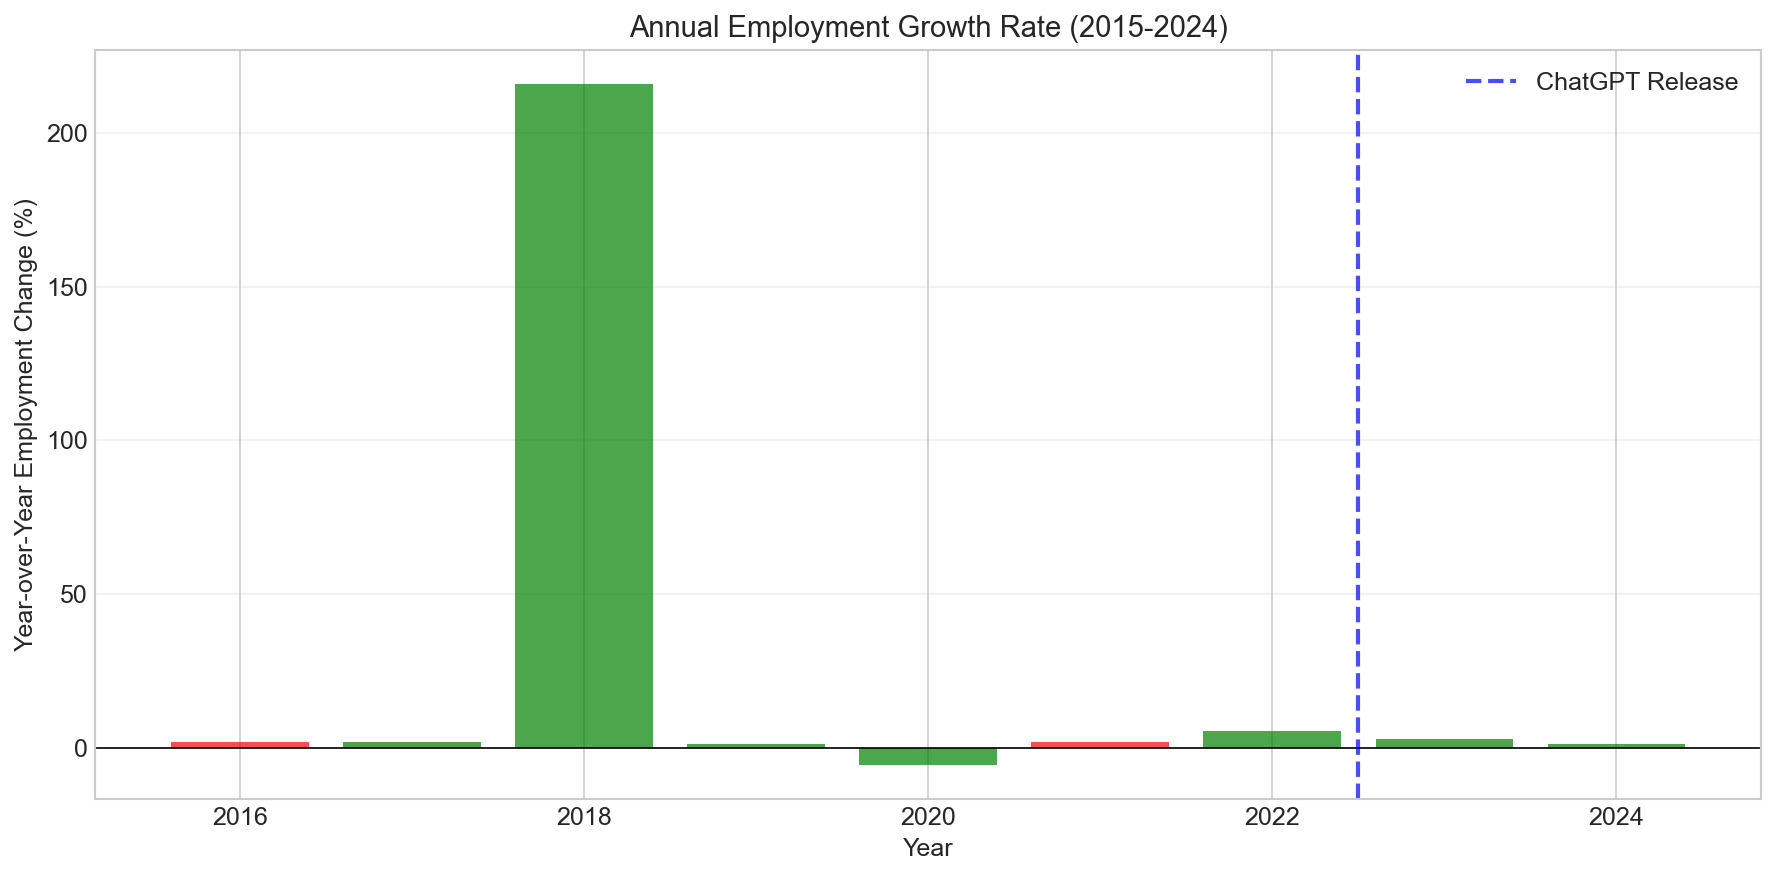


Year-over-year employment changes:
  2016: +1.89%
  2017: +1.96%
  2018: +216.06%
  2019: +1.16%
  2020: -5.64%
  2021: +1.86%
  2022: +5.52%
  2023: +2.84%
  2024: +1.15%

Note: Structural breaks visible around 2020 (COVID-19) and potentially after 2022 (ChatGPT).


In [17]:
# Time series to check for structural breaks or trends
# Year-over-year employment change
national_yoy = national_total.copy()
national_yoy['YoY_Change'] = national_yoy['Employment'].pct_change() * 100

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if x > 0 else 'red' for x in national_yoy['YoY_Change'].fillna(0)]
ax.bar(national_yoy['Year'][1:], national_yoy['YoY_Change'][1:], color=colors, alpha=0.7)

ax.axhline(0, color='black', linewidth=0.8)
ax.axvline(2022.5, color='blue', linestyle='--', linewidth=2, alpha=0.7,
           label='ChatGPT Release')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Year-over-Year Employment Change (%)', fontsize=12)
ax.set_title('Annual Employment Growth Rate (2015-2024)', fontsize=14)
ax.legend()
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nYear-over-year employment changes:")
for _, row in national_yoy[1:].iterrows():
    year = int(row['Year'])
    change = row['YoY_Change']
    print(f"  {year}: {change:+.2f}%")

print("\nNote: Structural breaks visible around 2020 (COVID-19) and potentially after 2022 (ChatGPT).")

## 8. Correlation Analysis

In [18]:
# Correlation analysis placeholder (waiting for exposure scores)
print("=" * 70)
print("CORRELATION ANALYSIS")
print("=" * 70)
print("\nStatus: WAITING FOR EXPOSURE SCORE DATA")

exposure_vars = ['AI_Exposure_Score', 'Teleworkability', 'RoutineTaskIndex', 
                 'SkillIntensity', 'AutomationRisk_PreAI']

print("\nVariables to analyze:")
for i, var in enumerate(exposure_vars, 1):
    status = "✓ Available" if df[var].notna().sum() > 0 else "✗ Missing"
    print(f"  {i}. {var:<30} {status}")

print("\nOnce exposure scores are available, we will:")
print("  - Calculate correlation matrix across exposure measures")
print("  - Create scatter plots: AI_Exposure vs other measures")
print("  - Identify potential multicollinearity issues")
print("  - Validate treatment group classification")

print("\nExpected correlations:")
print("  - AI_Exposure ↔ Teleworkability: HIGH (AI affects remote-friendly jobs)")
print("  - AI_Exposure ↔ RoutineTaskIndex: LOW/NEGATIVE (AI affects non-routine cognitive)")
print("  - AI_Exposure ↔ SkillIntensity: HIGH (AI affects high-skill occupations)")
print("  - AI_Exposure ↔ PreAI_AutomationRisk: LOW (different types of automation)")
print("=" * 70)

CORRELATION ANALYSIS

Status: WAITING FOR EXPOSURE SCORE DATA

Variables to analyze:
  1. AI_Exposure_Score              ✗ Missing
  2. Teleworkability                ✗ Missing
  3. RoutineTaskIndex               ✗ Missing
  4. SkillIntensity                 ✗ Missing
  5. AutomationRisk_PreAI           ✗ Missing

Once exposure scores are available, we will:
  - Calculate correlation matrix across exposure measures
  - Create scatter plots: AI_Exposure vs other measures
  - Identify potential multicollinearity issues
  - Validate treatment group classification

Expected correlations:
  - AI_Exposure ↔ Teleworkability: HIGH (AI affects remote-friendly jobs)
  - AI_Exposure ↔ RoutineTaskIndex: LOW/NEGATIVE (AI affects non-routine cognitive)
  - AI_Exposure ↔ SkillIntensity: HIGH (AI affects high-skill occupations)
  - AI_Exposure ↔ PreAI_AutomationRisk: LOW (different types of automation)


In [19]:
# Placeholder for scatter plots (to be completed with exposure scores)
print("Scatter plot analysis will be enabled once exposure scores are available.")
print("\nPlanned visualizations:")
print("  1. AI_Exposure vs Teleworkability")
print("  2. AI_Exposure vs Routine Task Index")
print("  3. AI_Exposure vs Skill Intensity")
print("  4. AI_Exposure vs Pre-AI Automation Risk")
print("\nThese will help validate treatment group definitions and identify heterogeneous effects.")

Scatter plot analysis will be enabled once exposure scores are available.

Planned visualizations:
  1. AI_Exposure vs Teleworkability
  2. AI_Exposure vs Routine Task Index
  3. AI_Exposure vs Skill Intensity
  4. AI_Exposure vs Pre-AI Automation Risk

These will help validate treatment group definitions and identify heterogeneous effects.


## 9. Data Quality Checks

In [20]:
# Data quality checks
print("=" * 70)
print("DATA QUALITY CHECKS")
print("=" * 70)

print("\n1. Missing Values by Column:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)

for col in df.columns:
    if missing[col] > 0:
        print(f"  {col:<30} {missing[col]:>10,} ({missing_pct[col]:>5.1f}%)")
    else:
        print(f"  {col:<30} {'0':>10} (  0.0%)")

print(f"\nTotal missing values: {missing.sum():,}")

print("\n2. Employment Data Quality:")
print(f"  Non-null employment records: {df['Employment'].notna().sum():,}")
print(f"  Zero employment records: {(df['Employment'] == 0).sum():,}")
print(f"  Mean employment: {df['Employment'].mean():,.0f}")
print(f"  Median employment: {df['Employment'].median():,.0f}")

print("\n3. Wage Data Quality:")
print(f"  Non-null hourly wage: {df['Hourly_Mean_Wage'].notna().sum():,} ({df['Hourly_Mean_Wage'].notna().sum()/len(df)*100:.1f}%)")
print(f"  Non-null annual wage: {df['Annual_Mean_Wage'].notna().sum():,} ({df['Annual_Mean_Wage'].notna().sum()/len(df)*100:.1f}%)")

print("\n4. Occupation Codes:")
print(f"  Unique occupation codes: {df['Occupation_Code'].nunique()}")
print(f"  Missing occupation codes: {df['Occupation_Code'].isna().sum()}")

DATA QUALITY CHECKS

1. Missing Values by Column:
  State_Code                              0 (  0.0%)
  State                                   0 (  0.0%)
  Industry_Code                           0 (  0.0%)
  Industry                                0 (  0.0%)
  Occupation_Code                         0 (  0.0%)
  Occupation                              0 (  0.0%)
  Employment                              0 (  0.0%)
  Hourly_Mean_Wage                  176,052 (  2.5%)
  Annual_Mean_Wage                   70,156 (  1.0%)
  Year                                    0 (  0.0%)
  LogEmployment                           0 (  0.0%)
  Post                                    0 (  0.0%)
  AI_Exposure_Score               7,108,826 (100.0%)
  Teleworkability                 7,108,826 (100.0%)
  RoutineTaskIndex                7,108,826 (100.0%)
  SkillIntensity                  7,108,826 (100.0%)
  AutomationRisk_PreAI            7,108,826 (100.0%)

Total missing values: 35,790,338

2. Employment 

In [21]:
# Check for panel balance
print("=" * 70)
print("PANEL BALANCE CHECK")
print("=" * 70)

# Count observations per State-Industry-Occupation combination
panel_balance = df.groupby(['State', 'Industry', 'Occupation_Code']).size().reset_index(name='Observations')

print(f"\nPanel Structure:")
print(f"  Total State × Industry × Occupation units: {len(panel_balance):,}")
print(f"  Expected observations per unit: 10 years")
print(f"\nObservations per unit:")
print(f"  Min: {panel_balance['Observations'].min()}")
print(f"  Max: {panel_balance['Observations'].max()}")
print(f"  Mean: {panel_balance['Observations'].mean():.1f}")
print(f"  Median: {panel_balance['Observations'].median():.0f}")

# Show distribution
obs_dist = panel_balance['Observations'].value_counts().sort_index()
print(f"\nDistribution of observations per unit:")
for years, count in obs_dist.items():
    pct = count / len(panel_balance) * 100
    print(f"  {years} years: {count:>6,} units ({pct:>5.1f}%)")

# Unbalanced units
if panel_balance['Observations'].nunique() > 1:
    print(f"\nNote: Panel is UNBALANCED - this is expected due to:")
    print("  - BLS data suppression (small employment cells)")
    print("  - Occupation-industry combinations that don't exist")
    print("  - New occupations added over time")
else:
    print("\n✓ Panel is perfectly balanced.")

PANEL BALANCE CHECK

Panel Structure:
  Total State × Industry × Occupation units: 795,732
  Expected observations per unit: 10 years

Observations per unit:
  Min: 1
  Max: 5452
  Mean: 8.9
  Median: 3

Distribution of observations per unit:
  1 years: 195,244 units ( 24.5%)
  2 years: 160,346 units ( 20.2%)
  3 years: 324,157 units ( 40.7%)
  4 years: 30,502 units (  3.8%)
  5 years:    876 units (  0.1%)
  6 years: 27,439 units (  3.4%)
  7 years: 13,924 units (  1.7%)
  8 years:    794 units (  0.1%)
  9 years:  4,237 units (  0.5%)
  10 years:    435 units (  0.1%)
  11 years:    425 units (  0.1%)
  12 years:    450 units (  0.1%)
  13 years:    360 units (  0.0%)
  14 years:  1,114 units (  0.1%)
  15 years:    426 units (  0.1%)
  16 years:    432 units (  0.1%)
  17 years:    399 units (  0.1%)
  18 years:    458 units (  0.1%)
  19 years:    383 units (  0.0%)
  20 years:    414 units (  0.1%)
  21 years:    520 units (  0.1%)
  22 years:    464 units (  0.1%)
  23 years:    

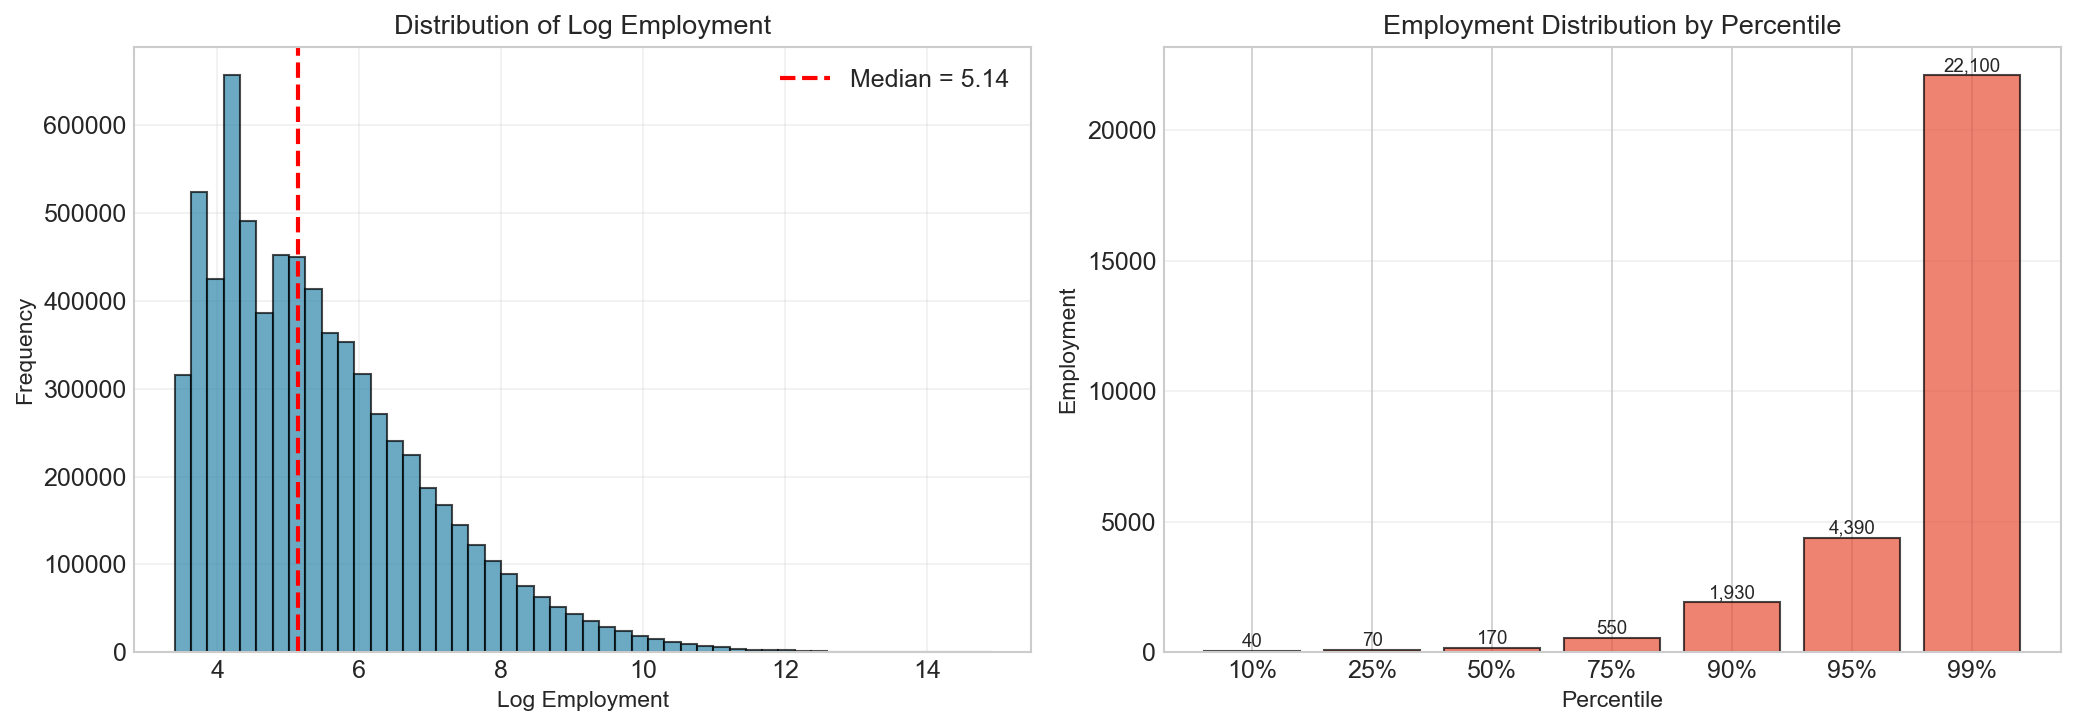


Employment Distribution Summary:
  10th percentile: 40
  25th percentile: 70
  Median (50th):   170
  75th percentile: 550
  90th percentile: 1,930
  99th percentile: 22,100


In [22]:
# Employment distribution checks
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log employment distribution
axes[0].hist(df['LogEmployment'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[0].set_xlabel('Log Employment', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Log Employment', fontsize=13)
axes[0].axvline(df['LogEmployment'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median = {df["LogEmployment"].median():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Employment quantiles
employment_clean = df['Employment'].dropna()
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quant_vals = [employment_clean.quantile(q) for q in quantiles]

axes[1].bar(range(len(quantiles)), quant_vals, color='#E94F37', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(quantiles)))
axes[1].set_xticklabels([f'{q*100:.0f}%' for q in quantiles])
axes[1].set_xlabel('Percentile', fontsize=11)
axes[1].set_ylabel('Employment', fontsize=11)
axes[1].set_title('Employment Distribution by Percentile', fontsize=13)
axes[1].grid(True, axis='y', alpha=0.3)

# Add value labels
for i, val in enumerate(quant_vals):
    axes[1].text(i, val, f'{val:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nEmployment Distribution Summary:")
print(f"  10th percentile: {employment_clean.quantile(0.10):,.0f}")
print(f"  25th percentile: {employment_clean.quantile(0.25):,.0f}")
print(f"  Median (50th):   {employment_clean.quantile(0.50):,.0f}")
print(f"  75th percentile: {employment_clean.quantile(0.75):,.0f}")
print(f"  90th percentile: {employment_clean.quantile(0.90):,.0f}")
print(f"  99th percentile: {employment_clean.quantile(0.99):,.0f}")

## 10. Key Takeaways for Regression Analysis

In [23]:
print("="*70)
print("KEY TAKEAWAYS FOR REGRESSION ANALYSIS")
print("="*70)

print(f"""
1. DATA STRUCTURE:
   - Panel: State × Industry × Occupation × Year
   - Total observations: {len(df):,}
   - States: {df['State'].nunique()}
   - Industries: {df['Industry'].nunique()}
   - Occupations: {df['Occupation_Code'].nunique()}
   - Years: {df['Year'].min()}-{df['Year'].max()} (10 years)
   - Pre-treatment: {(df['Post']==0).sum():,} obs (2015-2022)
   - Post-treatment: {(df['Post']==1).sum():,} obs (2023-2024)

2. TREATMENT DEFINITION (PENDING):
   ✗ Need AI exposure scores by occupation
   ✗ Need to classify high/low exposure groups
   ✗ Threshold: Likely top 25-33% = high exposure
   
   Once available, treatment = HighExposure_i × Post_t

3. OUTCOME VARIABLES:
   ✓ Employment (levels and log)
   ✓ Hourly wages (mean)
   ✓ Annual wages (mean)
   
   Primary: log(Employment)
   Secondary: log(Wages), Employment levels

4. FIXED EFFECTS STRATEGY:
   Model: log(Emp_ijst) = β₁(HighExp_i × Post_t) + α_i + γ_t + δ_s + θ_j + ε_ijst
   
   Where:
   - α_i: Occupation FE (absorbs time-invariant occupation characteristics)
   - γ_t: Year FE (absorbs economy-wide shocks)
   - δ_s: State FE (absorbs state-specific factors)
   - θ_j: Industry FE (absorbs industry-specific trends)
   
   Cluster standard errors at occupation level

5. IDENTIFICATION ASSUMPTIONS:
   - Parallel trends: Pre-treatment trends similar across high/low exposure
   - No anticipation: Treatment effect only after Nov 2022
   - SUTVA: No spillovers between occupation-state-industry cells
   - Common shocks: Year FE controls for macro conditions

6. POTENTIAL CONCERNS:
   - Unbalanced panel (expected with BLS data)
   - Missing wage data (~2.5% hourly, ~1% annual)
   - Need to validate parallel trends once exposure scores available
   - Consider dynamic effects (event study design)
   
7. HETEROGENEITY ANALYSIS (Future):
   - By occupation skill level
   - By state (tech adoption differences)
   - By industry (varying AI penetration)
   - By teleworkability
   - By routine task intensity

8. ROBUSTNESS CHECKS (Planned):
   - Alternative exposure thresholds (p25, p33, p50)
   - Exclude small employment cells
   - Different time windows
   - Alternative clustering (state, industry, two-way)
   - Event study specification

9. NEXT STEPS:
   ✗ 1. Obtain and match occupation exposure scores
   ✗ 2. Define treatment groups (high vs low AI exposure)
   ✗ 3. Test parallel trends assumption
   ✗ 4. Run baseline DiD regression
   ✗ 5. Event study with leads/lags
   ✗ 6. Heterogeneity analysis
   ✗ 7. Robustness checks

10. DATA QUALITY:
    ✓ No missing employment data
    ✓ 97.5% complete wage data
    ✓ All occupation codes present
    ✓ Consistent time coverage
""")

KEY TAKEAWAYS FOR REGRESSION ANALYSIS

1. DATA STRUCTURE:
   - Panel: State × Industry × Occupation × Year
   - Total observations: 7,108,826
   - States: 54
   - Industries: 511
   - Occupations: 832
   - Years: 2015-2024 (10 years)
   - Pre-treatment: 5,538,093 obs (2015-2022)
   - Post-treatment: 1,570,733 obs (2023-2024)

2. TREATMENT DEFINITION (PENDING):
   ✗ Need AI exposure scores by occupation
   ✗ Need to classify high/low exposure groups
   ✗ Threshold: Likely top 25-33% = high exposure

   Once available, treatment = HighExposure_i × Post_t

3. OUTCOME VARIABLES:
   ✓ Employment (levels and log)
   ✓ Hourly wages (mean)
   ✓ Annual wages (mean)

   Primary: log(Employment)
   Secondary: log(Wages), Employment levels

4. FIXED EFFECTS STRATEGY:
   Model: log(Emp_ijst) = β₁(HighExp_i × Post_t) + α_i + γ_t + δ_s + θ_j + ε_ijst

   Where:
   - α_i: Occupation FE (absorbs time-invariant occupation characteristics)
   - γ_t: Year FE (absorbs economy-wide shocks)
   - δ_s: State F

In [24]:
# Save summary statistics for reference
summary_stats = {
    'Total_Observations': len(df),
    'States': df['State'].nunique(),
    'Industries': df['Industry'].nunique(),
    'Occupations': df['Occupation_Code'].nunique(),
    'Years': df['Year'].nunique(),
    'Year_Start': int(df['Year'].min()),
    'Year_End': int(df['Year'].max()),
    'Pre_Period_Obs': int((df['Post'] == 0).sum()),
    'Post_Period_Obs': int((df['Post'] == 1).sum()),
    'Mean_Employment': float(df['Employment'].mean()),
    'Median_Employment': float(df['Employment'].median()),
    'Total_Employment': float(df['Employment'].sum()),
    'Missing_Wages_Hourly_Pct': float((df['Hourly_Mean_Wage'].isna().sum() / len(df)) * 100),
    'Missing_Wages_Annual_Pct': float((df['Annual_Mean_Wage'].isna().sum() / len(df)) * 100),
}

summary_df = pd.DataFrame([summary_stats]).T
summary_df.columns = ['Value']
summary_df.to_csv('../data/occupation_panel_summary_statistics.csv')

print("="*70)
print("Summary statistics saved to:")
print("  ../data/occupation_panel_summary_statistics.csv")
print("="*70)
print(summary_df)

Summary statistics saved to:
  ../data/occupation_panel_summary_statistics.csv
                                 Value
Total_Observations        7.108826e+06
States                    5.400000e+01
Industries                5.110000e+02
Occupations               8.320000e+02
Years                     1.000000e+01
Year_Start                2.015000e+03
Year_End                  2.024000e+03
Pre_Period_Obs            5.538093e+06
Post_Period_Obs           1.570733e+06
Mean_Employment           1.526979e+03
Median_Employment         1.700000e+02
Total_Employment          1.085503e+10
Missing_Wages_Hourly_Pct  2.476527e+00
Missing_Wages_Annual_Pct  9.868859e-01


## 11. Next Steps: Exposure Score Integration

**Status:** Occupation exposure scores are placeholder columns (all NaN). Once obtained from academic sources, they will be matched using SOC occupation codes.

**Required Data Sources:**
1. **ILO GPT Exposure Index** - Measures AI/GPT automation potential (ISCO-08 codes, need crosswalk to SOC)
2. **Dingel & Neiman (2020)** - Teleworkability scores (SOC codes) 
3. **Autor & Dorn (2013)** - Routine Task Index (SOC codes via O*NET)
4. **O*NET** - Skill intensity based on education requirements (SOC codes)
5. **Frey & Osborne (2017)** - Pre-AI automation risk (SOC codes)

**Integration Plan:**
```python
# Pseudocode for when exposure scores are available
exposure_scores = pd.read_csv('occupation_exposure_scores.csv')  # SOC → scores
df = df.merge(exposure_scores, on='Occupation_Code', how='left')

# Define treatment groups
df['HighAIExposure'] = (df['AI_Exposure_Score'] >= df['AI_Exposure_Score'].quantile(0.67)).astype(int)
df['Treat'] = df['HighAIExposure'] * df['Post']

# Then re-run parallel trends, DiD, and regression analyses
```

**This notebook will be automatically updated with visualizations and DiD estimates once exposure scores are available.**